# Introduction

Players engage with video games in many different ways. Some log in only for short sessions, while others spend much more time exploring and return more frequently. Beyond in-game activities, players also differ in how closely they stay connected to the game’s community. One way to stay engaged is by subscribing to the game’s newsletter for updates and upcoming events. Because subscription rates often reflect higher interest and community involvement, it’s useful to identify which types of players are more likely to subscribe. 

The two data sets, players.csv and sessions.csv, center on real data collected from the UBC Computer Science research group studying player behaviour on a Minecraft server. The goal for the research is to better target recruitment and ensure they have adequate server resources. 

To support the research group’s recruitment efforts, our project aims to answer the question: **Can the played hours, and age of a player predict whether or not they subscribed to the newsletter in the players dataset?** This helps determine which factors are most associated with engagement so the group can better tailor their efforts accordingly. 

To answer this question, we will only be working with players.csv, which includes data about all unique players. We won't be using the sessions dataset because it doesn't contain any relevant information that pertains to our specific question. 



The **players** dataset consists of 196 observations and 7 variables

|Variable Name|Data Type|Description|Stats|
|------------------|----------------------------|-------------|----------|
| experience | Character|experience level of the players at the game from beginner to regular to amateur to veteran to pro |N/A|
| subscribe| Logical|if the players are subscribed to the newsletter |N/A|
| hashed_email|Character|  unique encrypted way to identify each player |N/A|
| played_hours| Numeric|total hours the player has played the game |Mean=5.85, Max=223.1|
| name| Character|player's name|N/A|
| gender| Character| player's gender, either Male, Female, Other, Two Spirited, or Prefer not to say |N/A|
| Age | Numeric| players age in years| Mean=21.14, Max=58 |



**Why only played_hours and Age?**

*We won't be using variables like experience, or gender in our question due to the fact that they are not ideal for a knn-classification. This is due to the fact that they are categorical variables, and although it is possible to potentially convert them in a way that is usable in knn, we found that for this specific project, focusing on numerical variables like played_hours and age was sufficient*

The **sessions** dataset has has 1,535 Observations and 5 variables
|Variable Name|Data Type  | Description 
|------------------|----------------------------|-------------|
| hashedemail | Character| same as from players: unique encrypted way to identify each player |
| start_time| Character|start of the play session|
| end_time|Character| end of the play session |
| original_start_time| Double| original start time of the session, recorded in unex units milliseconds|
| original_end_time| Double| original end time of the session, recorded in unex units milliseconds|

#### Possible Limitations:
- Outliers: played_hours' mean value is 5.85 hours played, but the maximum value in the dataset is 223.1. This can potentially be an issue since KNN is distance based and sensitive to outliers, especially with smaller datasets such as this.
- Sampling Biases: This dataset only includes players from a specific server, neglecting players who may primarily play on other servers



# Questions

### *Broad Question:*

What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

### *Specific Question:*

 Can the played hours, and age of a player predict whether or not they subscribed to the newsletter in the players dataset?


# Methods (Narration)

We start by loading the R libraries we need for this analysis. 


In [49]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
library(purrr)
options(repr.matrix.max.rows = 6)


## **Data Preparation**

First, we import the players.csv dataset and clean it up. The variables gender, experience level, and subscription status are converted to factors. Gender and experience level both only make sense as factors, but for subscribe, while it could be plausible as a logical data type, we converted it to a factor so when we eventually use it in the model, it is treated as a categorical outcome. Additionally, the subscription variable originally uses TRUE/FALSE, so we reworded it to “Yes” and “No” for clarity. We select for only subscribe, played_hours, and Age since those are the only variables we will be working with. Any rows with missing values are also dropped to make sure the modeling runs smoothly. 

In [50]:
players<-read_csv("https://raw.githubusercontent.com/RadinAlikhani/DSCI-100-GROUP-PROJECT-REPOSITORY/refs/heads/main/players.csv")|>
    mutate(gender=as_factor(gender),experience=as_factor(experience),subscribe=as_factor(subscribe))|>
    mutate(subscribe=fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"))|>
    select(played_hours,subscribe,Age)|>
    drop_na()

players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


played_hours,subscribe,Age
<dbl>,<fct>,<dbl>
30.3,Yes,9
3.8,Yes,17
0.0,No,17
⋮,⋮,⋮
0.3,No,22
0.0,No,57
2.3,No,17


Afterwards, we do a summary of the dataset's statistics to have a general outlook on the variables and their variability

In [51]:
players_summary<-summary(players)
players_summary

  played_hours     subscribe      Age       
 Min.   :  0.000   No : 52   Min.   : 9.00  
 1st Qu.:  0.000   Yes:142   1st Qu.:17.00  
 Median :  0.100             Median :19.00  
 Mean   :  5.905             Mean   :21.14  
 3rd Qu.:  0.600             3rd Qu.:22.75  
 Max.   :223.100             Max.   :58.00  

## **Exploratory Data Analysis**

To get a quick sense for the data, we created a few plots:

- A histogram showing the relationship between subscription status and hours played on the server.
- A boxplot showing the age of subscribers versus non-subscribers.
- A scatterplot of age versus hours played to see if certain age and playtime combinations are linked to subscription.

These visualizations give a quick overview of how the predictors relate to subscription and help us see what patterns might exist before modeling.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


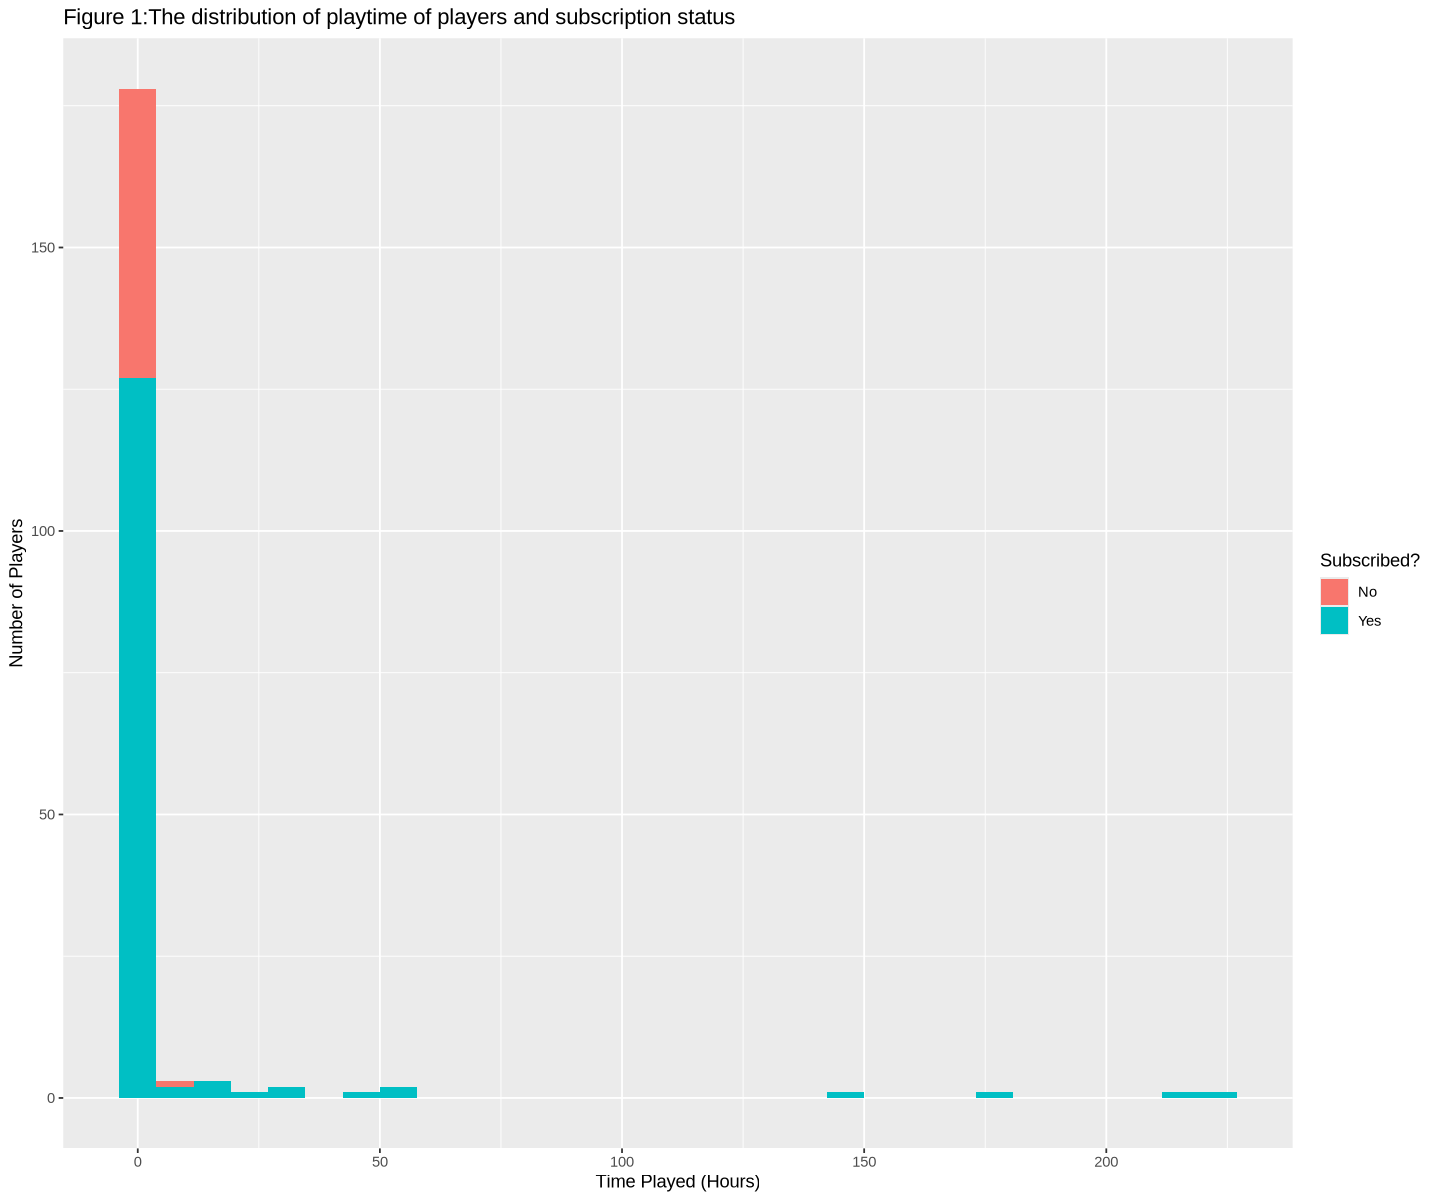

In [52]:
options(repr.plot.width=12,repr.plot.height=10)
played_time_plot<-players|>
    ggplot(aes(x=played_hours,fill=subscribe))+
    geom_histogram()+
    labs(x="Time Played (Hours)",y="Number of Players",fill="Subscribed?")+
    ggtitle("Figure 1:The distribution of playtime of players and subscription status")
played_time_plot








## Plot Observations


#### Figure 1:
- players with more than 25 hours played tend to be subscribed in a higher proportion compared to players with less than 25 hours played.
- Can help distinguish between the different hours and subscription status
- Due to these points, played_hours will most likely be a useful predictor, however since practically all players above 20 hours played **are** subscribed, it may not be as useful 

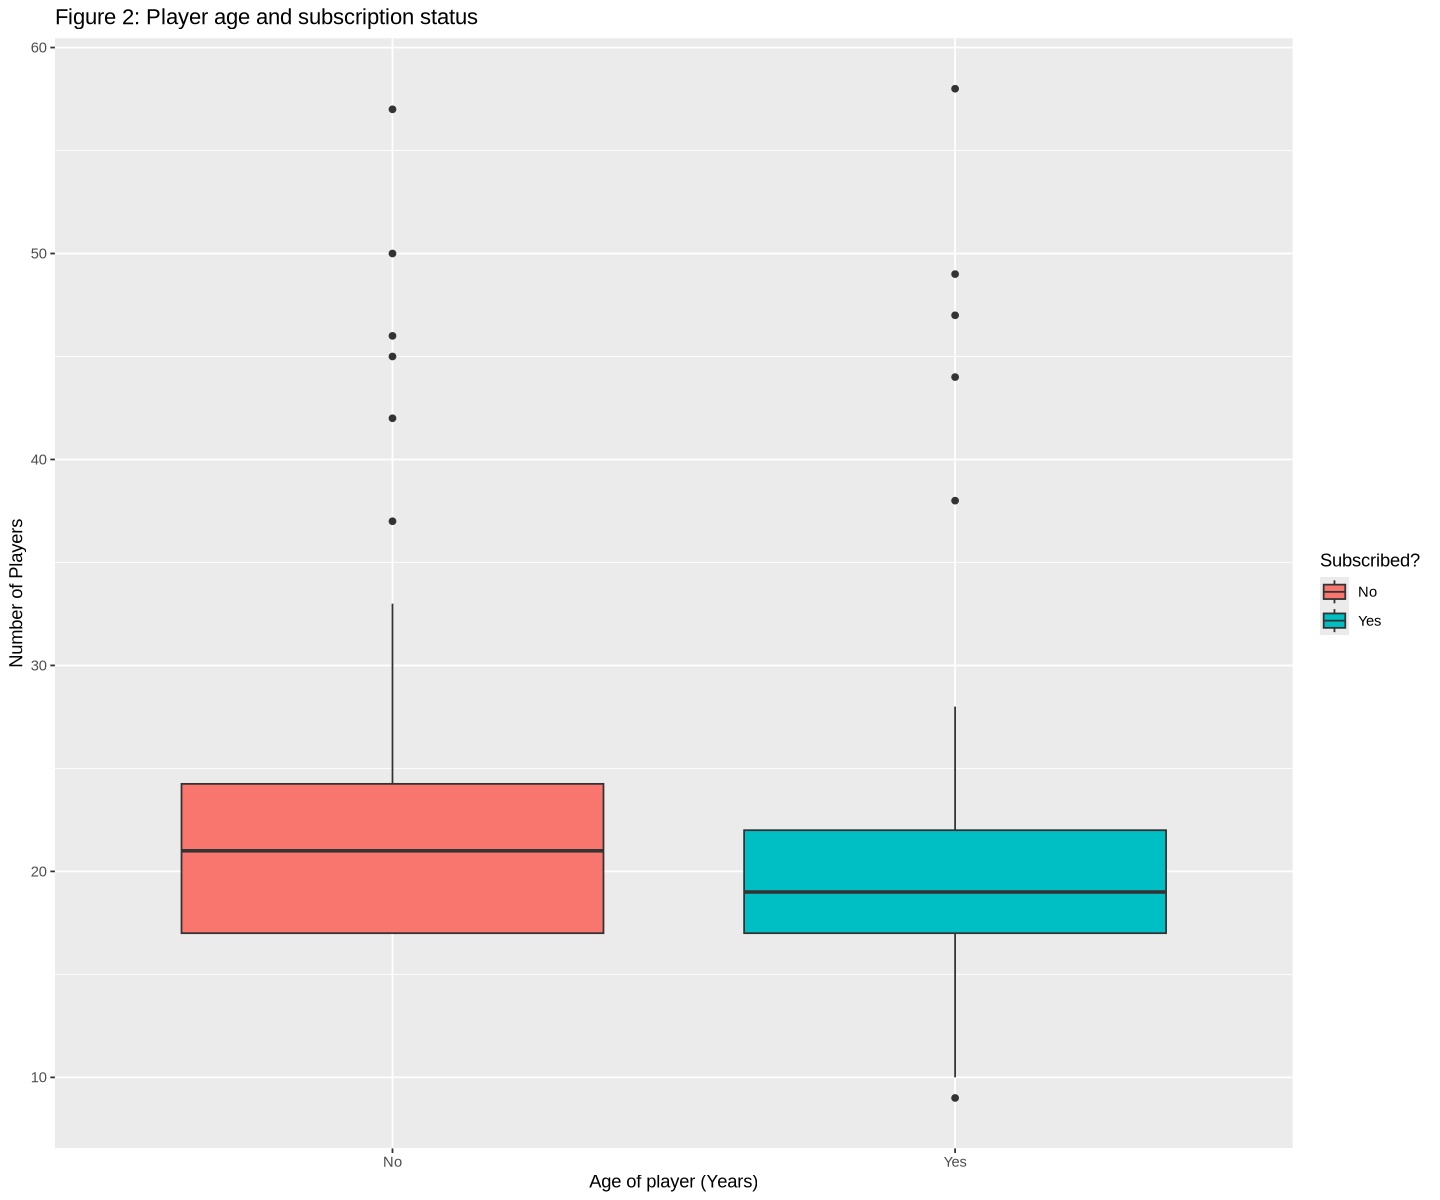

In [53]:
age_plot<-players|> 
    ggplot(aes(y=Age,x
               =subscribe, fill=subscribe))+
    geom_boxplot()+
    labs(x="Age of player (Years)",y="Number of Players",fill="Subscribed?")+
    ggtitle("Figure 2: Player age and subscription status")
age_plot

#### Figure 2
- The median age of non subscribers (~ 23) was higher than the median age of subscribers (~ 18)
- Most players fall within the 10-30 age range
- This suggest that Age can be used as a predictor since there is a notable difference between non-subscribers and subscribers' age median age.

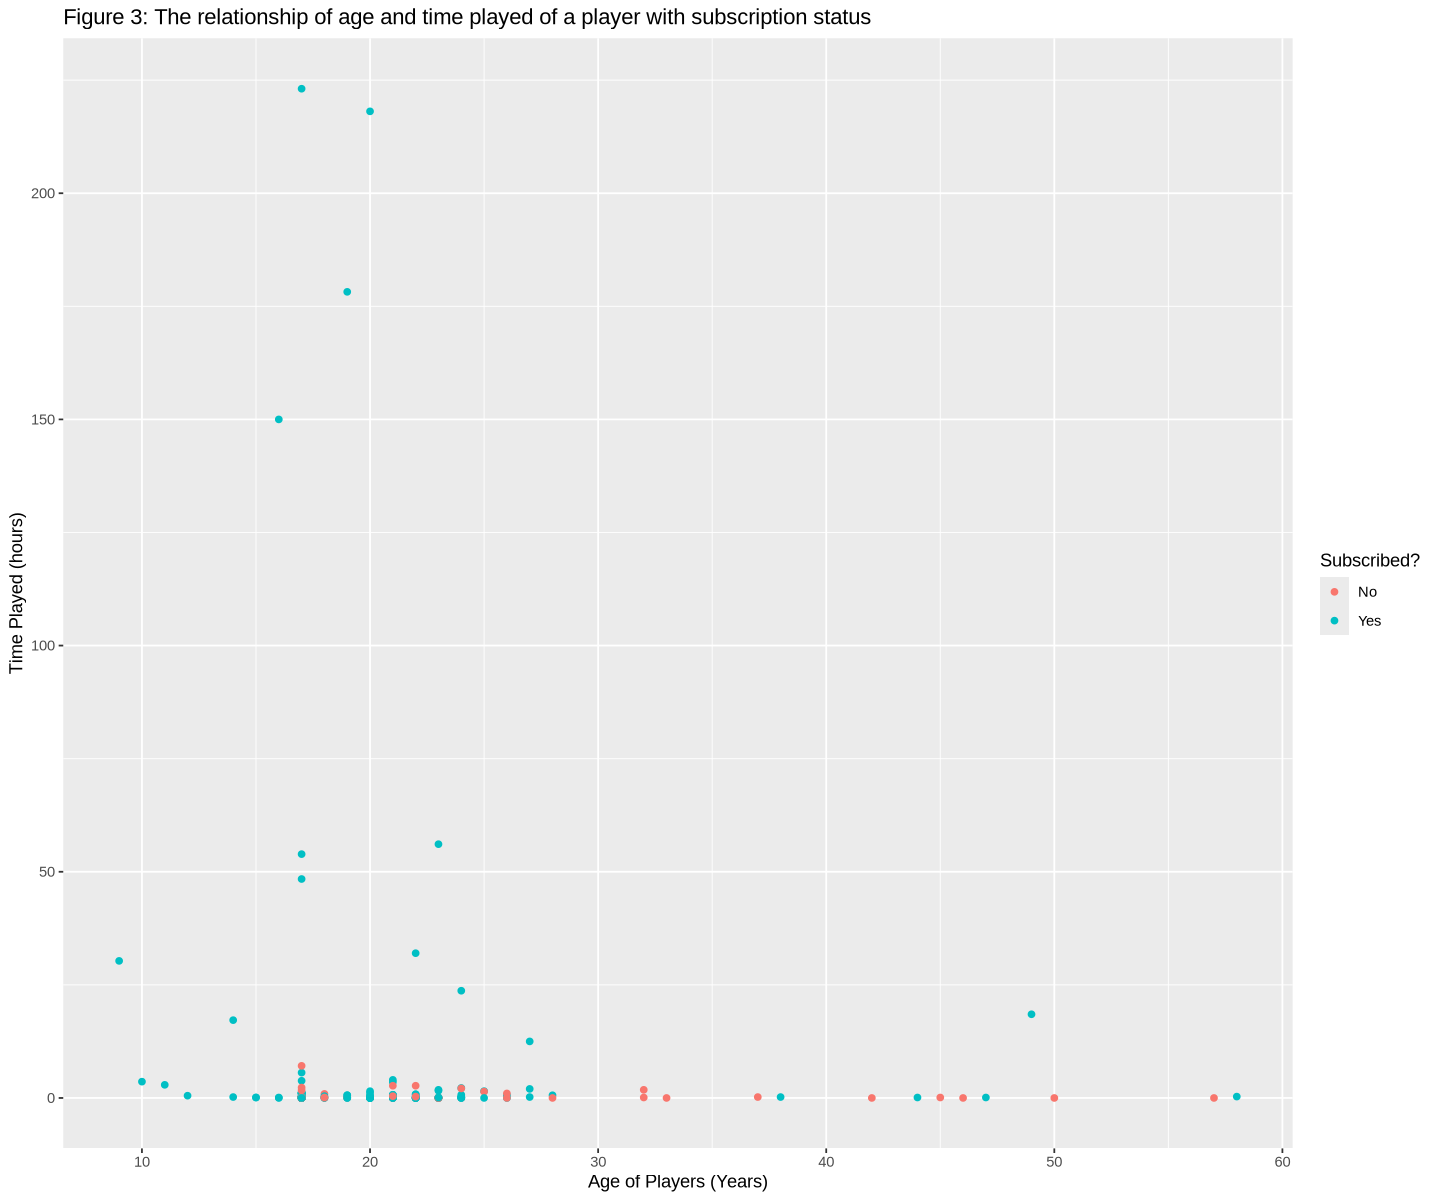

In [54]:
age_and_time_plot<-players|>
    ggplot(aes(x=Age,y=played_hours,color=subscribe))+
    geom_point()+
    labs(x="Age of Players (Years)",y="Time Played (hours)",color="Subscribed?")+
    ggtitle("Figure 3: The relationship of age and time played of a player with subscription status")
age_and_time_plot

#### Figure 3
- Players in the age range of 10-20 have more hours on average compared to higher ages
- most players are condensed within 10-30 age range
- younger players are more likely to play more and subscribe more often
- Time played has a wider range and variability than Age

**Modeling Approach**

We use k-nearest neighbors (KNN) classification to predict a player’s subscription status using Age and played_hours as predictors and subscribe as the response variable. As discussed above, we do not include experience level or gender because KNN requires numerical predictors.

KNN is appropriate here because the response variable that we are trying to predict for (subscribe) is categorical, and the predictors (Age, and played_hours) are numerical. Since KNN is non-parametric, it can capture non-linear relationships and is flexible, which is another reason why it is appropriate for our specific question. To apply KNN to a dataset, we must assume that, both, the data is tidy and that all predictors contribute equally. Since we have already wrangled the dataset to ensure tidiness, we will now standardize the predictors using centering and scaling with a recipe. This is especially important because *time_played* has a wider range (0-250) compared to *Age* (0-60) meaning that without scaling, it would, unevenly, contribute more to the model.

Knowing that we are working with a smaller dataset (196 observations), the data is split into a training set (75%) and a test set (25%) while keeping the same proportion of subscribers in each set. Standardization is applied only to the training set using step_center and step_scale.

For preprocessing, we tune the number of neighbors k from 1 to 30 and use 5-fold cross-validation on the training data to identify the most accurate value of k. We only tested on values from 1-30 as the accuracy plateaued beyond this range.

*To ensure that the data is reproducible and produces the same results every time it is run, we set a seed (1) before every randomization event, splitting the data, making the recipe, and cross validation*

In [55]:


set.seed(1)
players_split<-initial_split(players,prop=0.75,strata=subscribe)
players_train<-training(players_split)
players_test<-testing(players_split)

set.seed(1)
players_recipe<-recipe(subscribe~played_hours+Age,data=players_train)|>
step_scale(all_predictors())|>
step_center(all_predictors())


set.seed(1)
players_vfold<-vfold_cv(players_train,v=5,strata=subscribe)

knn_spec<-nearest_neighbor(weight_func="rectangular",neighbors=tune())|>
set_engine("kknn")|>
set_mode("classification")

k_vals<-tibble(neighbors=seq(from=1,to=30,by=1))
               
knn_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")
 

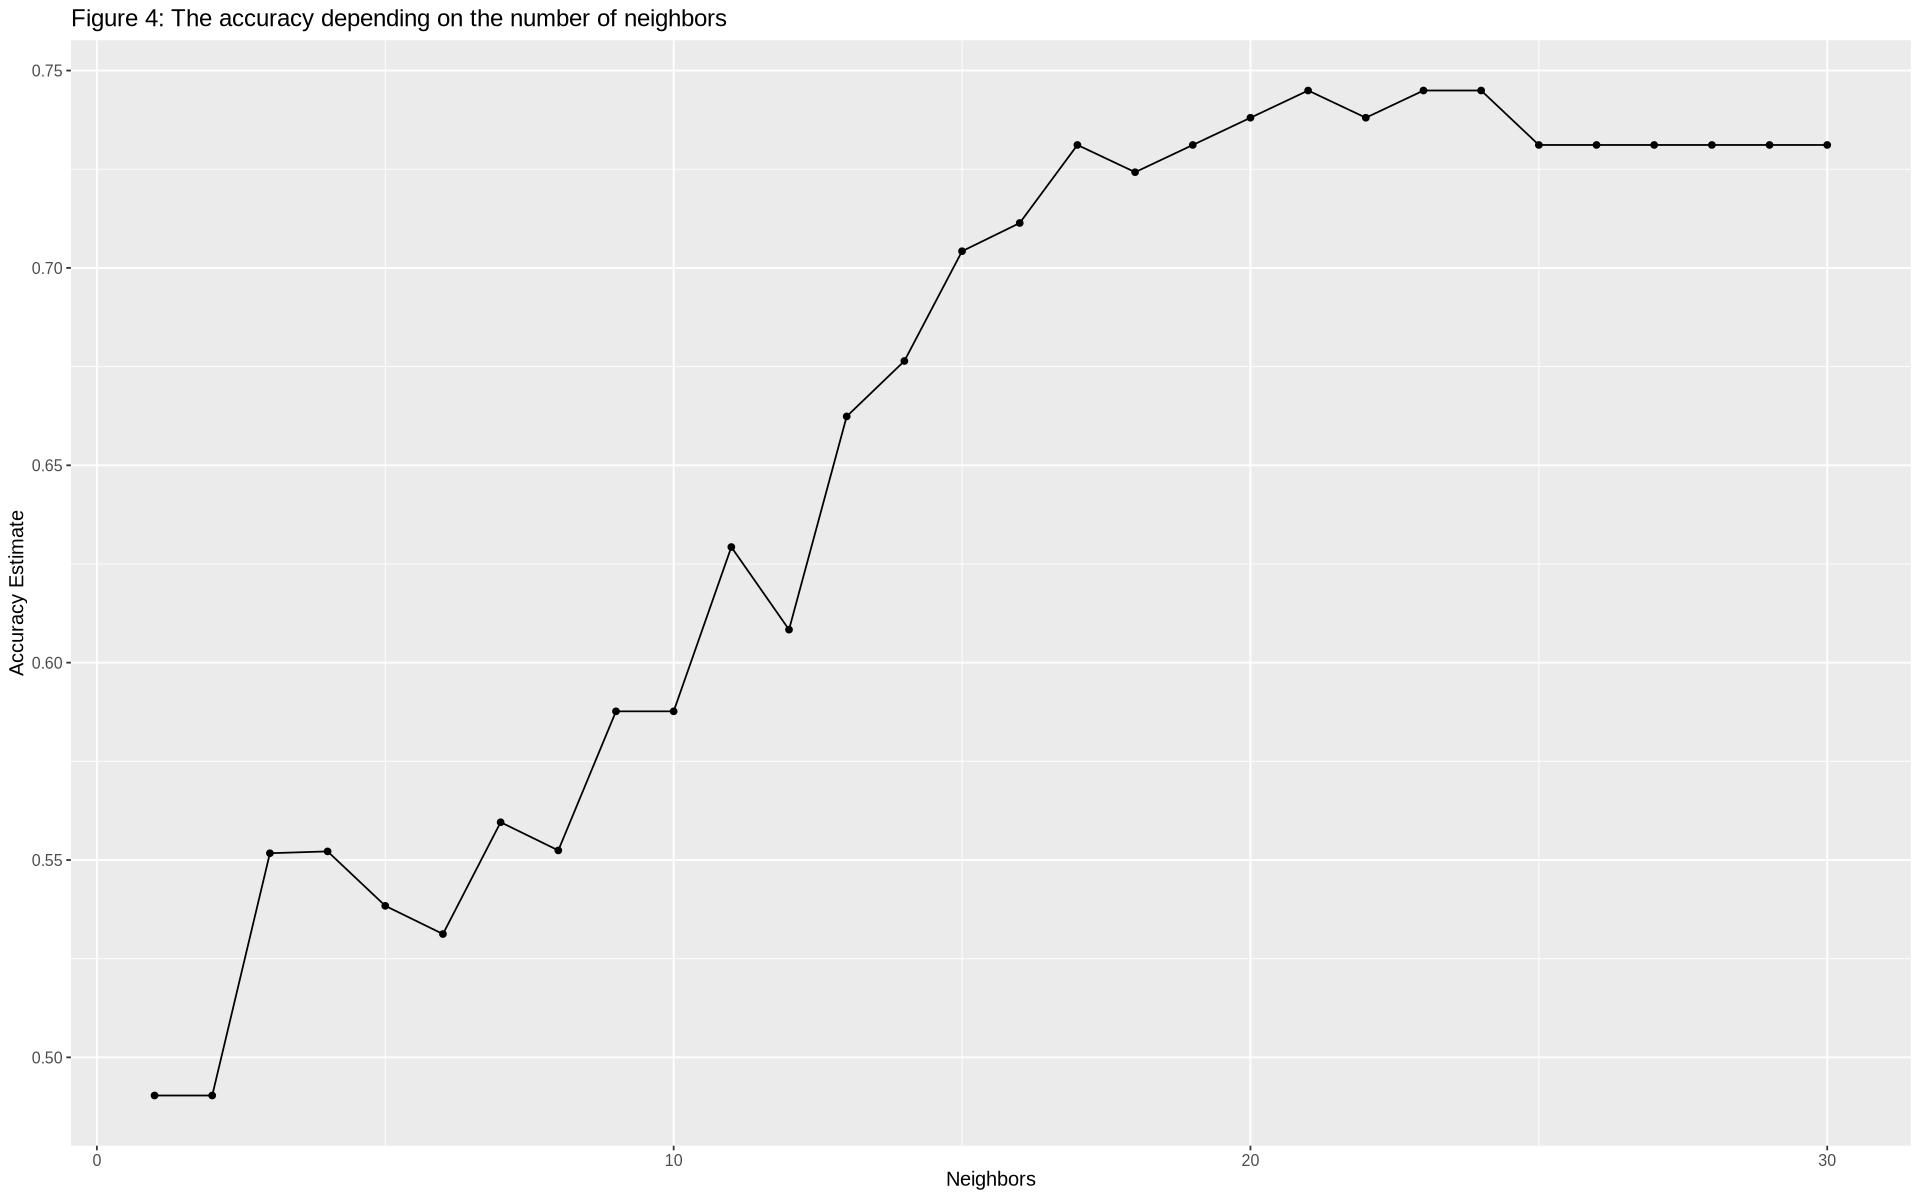

In [56]:
options(repr.plot.width=16,repr.plot.height=10)      
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  ggtitle("Figure 4: The accuracy depending on the number of neighbors")+
  theme(text = element_text(size = 12))

accuracy_vs_k

#### Plot analysis (Figure 4)
From k values of 0 to around 15 we see a steady increase in accuracy, and an overall peak at 21 neighbors. After 21, it starts to decline in accuracy and stay constant in accuracy


From the graph above, we can see that the k value with the highest accuracy is **21**.



After selecting the best k (21), the code trains a final KNN model on the full training set using this k value for the highest accuracy, and then evaluates it on the test data by determining its accuracy. This allows us to see how well age and playtime can actually predict which players are more engaged and likely to subscribe. Additionally, while accuracy is important, we also want to fully understand our results to a more complex level, which is why we will also use a confusion matrix to see if our predictor is better in predicting Recall or Precision.


In [57]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

best_knn<-nearest_neighbor(weight_func="rectangular",neighbors=best_k)|>
set_engine("kknn")|>
set_mode("classification")

knn_fit<-workflow()|>
add_recipe(players_recipe)|>
add_model(best_knn)|>
fit(data=players_train)
knn_fit

players_test_predictions <- predict(knn_fit, players_test) |>
  bind_cols(players_test)

players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_test_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)

[1] 21

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(21,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2689655
Best kernel: rectangular
Best k: 21

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


          Truth
Prediction No Yes
       No   1   1
       Yes 12  35

## Conclusion
Using our new model with the most accurate number of neighbors (21) and testing it with the test data, we got around 73.47% accuracy. This means that it will get the correct prediction 73.47% of the time. However, accuracy itself doesn't show the whole story. Looking deeper into this result by inspecting the confusion matrix, we can see that our model is more likely to predict subscribers than non-subscribers. Two more important metrics that we can calculate are precision, and recall. Precision helps determine how many of the people that the model predicted to be subscribed actually are, while recall helps determine how accurate it is when predicting how many of the actual subscribers the model correctly predicted. Calculating both precision and recall, we find that the model had a precision of around 74.5% and a recall of around 97.2%. Since it overpredicts "Yes", this can shed some light on some biases and inaccuracies within the model.

Overall, these results show that a player's age and played hours can give some indication of subscription behavior but it does not fully define or explain it. This aligns with what we expected. It's reasonable that players with higher playtime increase the chance of subscribing, and age may influence the user's interests or habits. However, there are still many other factors in the dataset that we didn't take into account when making this model, so it makes sense that these two factors won't completely determine subscription outcomes by themselves.

These insights could help guide targeted engagement strategies since it allows them to better understand the demographic of players that are likely to subscribe to the newsletter. For example, the company could focus marketing efforts on players with higher playtime or certain age groups, especially within the 10-20 years demographic, to make subscription campaigns more efficient.

This analysis also raises further questions. Would adding more factors (experience level, gender, etc.) improve prediction? Is KNN the best prediction model? Exploring these questions could help lead to more accurate and effective results.

Github Repository:
https://github.com/RadinAlikhani/DSCI-100-GROUP-PROJECT-REPOSITORY.git